In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import pandas as pd

C:\Users\ircguest\.conda\envs\new_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'C:\\Users\\ircguest\\Downloads\\capstone-eemb-patrick-main\\capstone-eemb-patrick-main\\scripts'

### Resize the pictures

In [4]:
def resize_image(src, size = (128, 128)):
    src_image = cv2.imread(src)
    new_image = cv2.resize(src_image, size)
    return new_image

In [43]:
src = "64-coil-0.0.png"
new_image = resize_image(src)
cv2.imwrite("../tryout.png", new_image)

True

In [50]:
train_folder = "C:\\Users\\ircguest\\Downloads\\train"
output_folder = "C:\\Users\\ircguest\\Downloads\\resize-train"

for root, folders, files in os.walk(train_folder):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # create a matching folder in the output dir
        saveFolder = os.path.join(output_folder, sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        file_names = os.listdir(os.path.join(root, sub_folder))
        for file_name in file_names:
            # open the file
            file_path = os.path.join(root, sub_folder, file_name)
            
            # resize the image
            new_image = resize_image(file_path)
            
            # get the save directory
            saveAs = os.path.join(saveFolder, file_name)
            
            # save the image
            cv2.imwrite(saveAs, new_image)

print("Done.")

processing folder coil
processing folder spread
processing folder strike
Done.


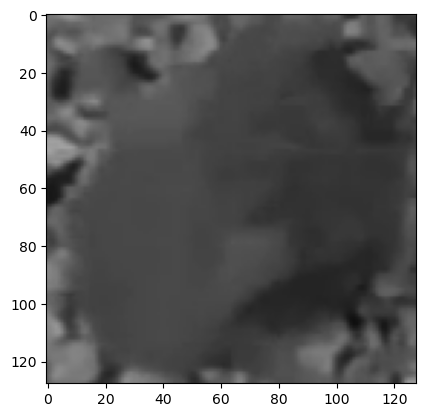

In [5]:
src = 'C:\\Users\\ircguest\\Downloads\\capstone-eemb-patrick-main\\capstone-eemb-patrick-main\\scripts\\64-coil-0.0.png'
new_image = resize_image(src)
plt.imshow(new_image)

### Load the datasets

In [31]:
def load_dataset(data_path):
    # augment the data by random vertical and horizontal flip
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels = 1),
        # normalize the pixel values in R, G, B channels
#         transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        # normalize the pixel values in grayscale channel
        transforms.Normalize(mean = 0.5, std = 0.5)
    ])
    
    # load all the images and transform them
    full_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transformation
    )
    
    # split in to training and testing sets
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
#     return train_dataset, test_dataset

    # define a loader for the training data to iterate through 50 images batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 64,
        num_workers = 0,
        shuffle = False
    )
    
    # define a loader for the testing data we can iterate through 50 images batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = 64,
        num_workers = 0,
        shuffle = False
    )
    
    return train_loader, test_loader

In [32]:
train_folder = "C:\\Users\\ircguest\\Downloads\\resize-train"
train_loader, test_loader = load_dataset(train_folder)
# batch_size = train_loader.batch_size
# print("Data loaders ready", train_folder)
# print("Batch size is", batch_size)

In [34]:
# inspect the data in the train loader
for data, target in train_loader:
    print(data.shape)

torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([28, 1, 128, 128])


In [136]:
# unsqueeze the data
class Unsqueezeit(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, idx):
        tensor = self.data[idx]
        
        # unsqueeze it
        tensor = tensor.unsqueeze(0)
        
        return tensor
    def __len__(self):
        return len(self.data)

data = [torch.randn(3, 128, 128), torch.randn(3, 128, 128), torch.randn(3, 128, 128)]

# Create an instance of the dataset
dataset = Unsqueezeit(data)

# Iterate over the dataset and unsqueeze all tensors
for idx in range(len(dataset)):
    tensor = dataset[idx]
    print(tensor.size())  # Output: torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


### Define the CNN

In [35]:
class Net(nn.Module): # add nn.module as baseclass(superclass)
    def __init__(self, num_classes):
        super(Net, self).__init__()
        # define each layer we will use in the model
        # since the input images are grayscaled, the input channel is 1
        # the first convolution layer has 12 output channels (12 filters)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 3, stride =1 , padding = 1)
        
        # the second convolution layer takes 12 inputs and outputs 24, which means 24 filters are used
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride = 1, padding = 1)
        
        # apply max pooling to reduce dimensionality
        self.pool = nn.MaxPool2d(kernel_size = 2)
        
        # A drop layer deletes 20% 
        self.drop = nn.Dropout2d(p = 0.2)
        
        # a 64 image tensors will be pooled twice with a kernel size of 2. 128/2/2 = 32
        # thus, we are having 24 features images with size 16x16
        
        # flatten the result
        self.fc = nn.Linear(in_features = 32 * 32 * 24, out_features = num_classes)
        
    def forward(self, x):
        # pass the data through the layers we defined in the init function
        
        # use a ReLU activation function after layer 1 and 2
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        
        x = F.dropout(self.drop(x), training = self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # feed to fully-connected layer to predict class
        x = self.fc(x)
        # return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim = 1)
    
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
model = Net(num_classes = 3).to(device)

print(model)


Net(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)


In [36]:
# train function 
def train(model, device, train_loader, optimizer, epoch):
    # set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        # use the cpu or gpu as appropriate
        data, target = data.to(device), target.to(device)
        
        # reset the optimizer
        optimizer.zero_grad()
        
        # push the data forward throught the model layers
        output = model(data)
        
        # get the loss
        loss = loss_criteria(output, target)
        
        # keep a running total
        train_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
        # print metrices so we can see more progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx + 1)
    print('Training set: Average loss: {:.6f}'. format(avg_loss))
    return avg_loss

In [37]:
# test function
def test(model, device, test_loader):
    # switch the model to evaluation mode
    # no backpropagation or drop
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # get the predicted classes for this batch 
            output = model(data)
            
            # calculate the loss for this batch 
            test_loss += loss_criteria(output, target).item()
            
            # calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}. Accuracy: {}/{} ({:.0f}%)\n'. format(
        avg_loss, correct, len(test_loader.dataset), 
    100. * correct / len(test_loader.dataset)))
    return avg_loss

In [19]:
output = torch.tensor([[0.2, 0.5, 0.8], 
                      [0.6, 0.3, 0.9]])
max_values, max_indices = torch.max(output.data, 0)
print(max_values)
print(max_indices)

tensor([0.6000, 0.5000, 0.9000])
tensor([1, 0, 1])


In [115]:
# use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track matrices in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# train over 10 epochs 
epochs = 10
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
	Training batch 1 Loss: 0.157194
	Training batch 2 Loss: 0.213476
	Training batch 3 Loss: 0.117357
	Training batch 4 Loss: 0.090380
	Training batch 5 Loss: 0.229264
	Training batch 6 Loss: 0.105580
	Training batch 7 Loss: 0.053414
	Training batch 8 Loss: 0.326406
	Training batch 9 Loss: 0.145337
	Training batch 10 Loss: 0.252962
	Training batch 11 Loss: 0.132987
	Training batch 12 Loss: 0.202548
	Training batch 13 Loss: 0.081298
	Training batch 14 Loss: 0.285265
	Training batch 15 Loss: 0.134013
	Training batch 16 Loss: 0.048080
	Training batch 17 Loss: 0.356146
Training set: Average loss: 0.172453
Validation set: Average loss: 0.077362. Accuracy: 442/452 (98%)

Epoch: 2
	Training batch 1 Loss: 0.261545
	Training batch 2 Loss: 0.120034
	Training batch 3 Loss: 0.085283
	Training batch 4 Loss: 0.141931
	Training batch 5 Loss: 0.257116
	Training batch 6 Loss: 0.257656
	Training batch 7 Loss: 0.105966
	Training batch 8 Loss: 0.233127
	Training batch 9 Loss: 0.092255
	Training batc

### Plot loss history

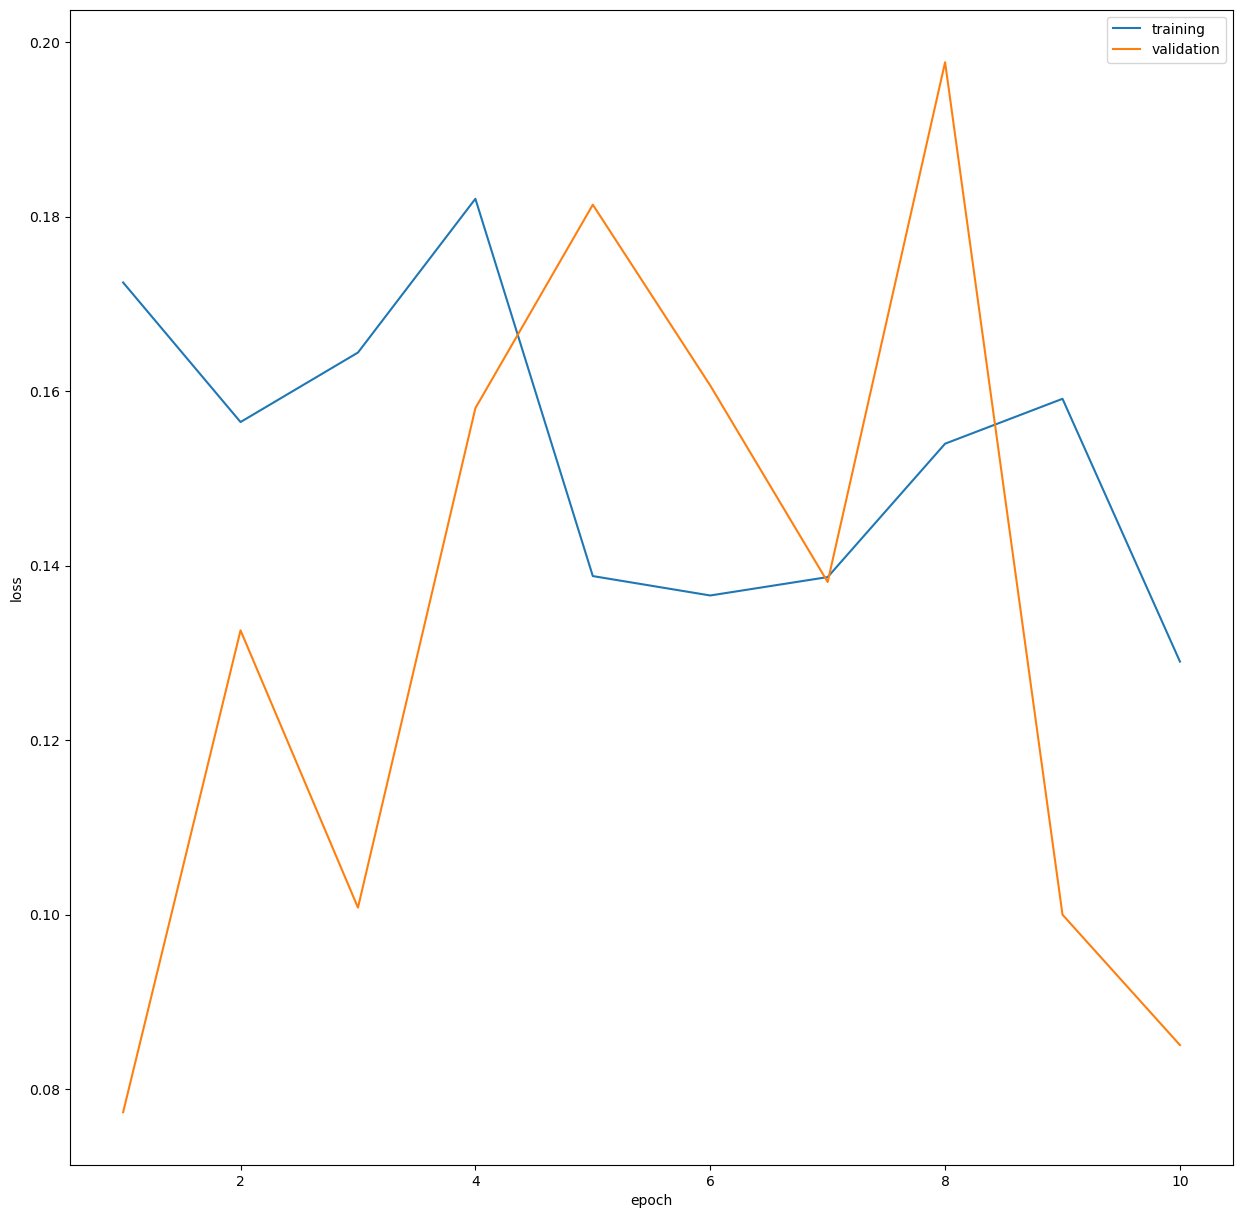

In [116]:
plt.figure(figsize = (15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc = 'upper right')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns

In [41]:
classes = sorted(os.listdir(train_folder))
print(classes)

['coil', 'spread', 'strike']


Getting predictions from test set...


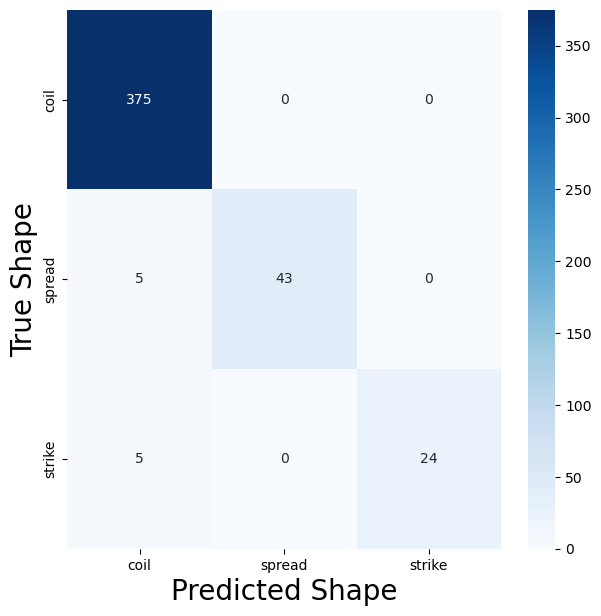

In [117]:
# Defining Labes and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction)
        
# plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

### Make Predictions

In [118]:
trans = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

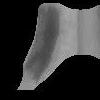

In [119]:
from PIL import Image
image = Image.open('C:\\Users\\ircguest\\Downloads\\training data-selected\\meral-spread (SQUARE CROP)\\spreads2\\spread_frame9.jpg')
image

In [120]:
pred_data = trans(image)
pred_data = pred_data.view(1,1,128,128)
output = model(pred_data)
prediction = int(torch.max(output.data, 1)[1].numpy())
print(prediction)

1


In [121]:
output

tensor([[-9.5063e+00, -6.4388e-04, -7.4710e+00]],
       grad_fn=<LogSoftmaxBackward0>)